In [1]:
%pip install matplotlib
%matplotlib inline

Learning shallow quantum circuits with local inversions and circuit sewing
==========================================================================

.. note::
    This tutorial is a Catalyst adaptation of the
    [Shallow Quantum Circuits tutorial](https://pennylane.ai/qml/demos/tutorial_learningshallow/)
    by Korbinian Kottmann.

In a recent paper [Learning shallow quantum
circuits](https://arxiv.org/abs/2401.10095), Huang et al introduce and
prove performance bounds on efficient algorithms to learn constant depth
circuits. At the heart of the paper lie local inversions that locally
undo a quantum circuit, as well as a circuit \"sewing\" technique that
lets one construct a global inversion from those. We are going to review
these new concepts and showcase them with an implementation in
PennyLane.

Importing PennyLane and Catalyst
--------------------------------

In order to use PannyLane with the Catalyst compiler, we need to import several important components:

- The [PennyLane](https://pennylane.ai/) framework in order to access the base QML API,
- The [Catalyst](../index.rst) Python package,
- The JAX version of NumPy.

In [2]:
import pennylane as qml
from catalyst import qjit, grad
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten

Introduction
------------

Shallow, constant depth quantum circuits are provably powerful. At the
same time, they are known to be difficult to train. The authors of
tackle the question of whether or not shallow circuits are efficiently
learnable.

Given some unknown unitary circuit $U$, learning the circuit constitutes
finding a unitary $V$ that faithfully resembles $U$\'s action. This can
be either fully performing the same operation ($U V^\dagger = 1$) or
resembling the action on a fixed input state
($U |\phi\rangle = V |\phi\rangle$, where often
$|\phi\rangle = |0 \rangle^{\otimes n}$). The authors go through both
scenarios with different levels of restrictions on the allowed gate set
and locality of the target circuit $U$. In this demo, we are mainly
going to focus on learning the action on $|0 \rangle^{\otimes n}$, i.e.
$U |0\rangle^{\otimes n} = V |0\rangle^{\otimes n}$.

At the heart of the solutions to all these scenarios lies the use of
local inversions that undo the effect of the unitary, and sewing them
together to form a global inversion.

Local Inversions
----------------

A local inversion is a unitary circuit that locally disentangles one
qubit after a previous, different unitary entangled them. Let us make an
explicit example in PennyLane after some boilerplate imports. Let us
look at a very shallow unitary circuit
$U^\text{test} = \text{CNOT}_{(0, 1)}\text{CNOT}_{(2, 3)}\text{CNOT}_{(1, 2)} H^{\otimes n}$.


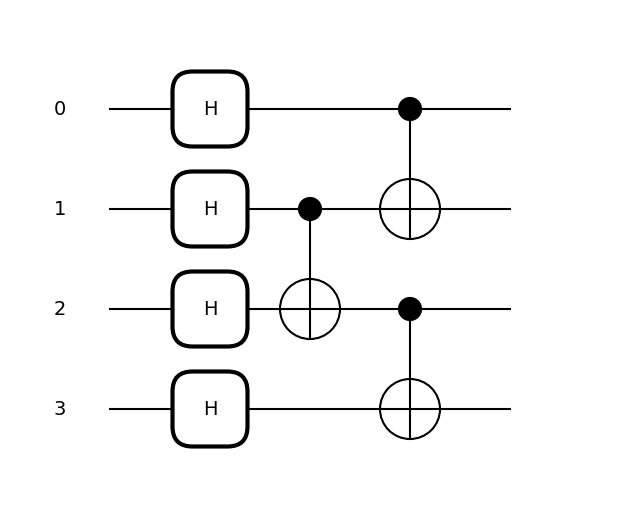

In [3]:
import matplotlib.pyplot as plt
n = 4 # number of qubits

def U_test():
    for i in range(n):
        qml.Hadamard(i)
    qml.CNOT((1, 2))
    qml.CNOT((2, 3))
    qml.CNOT((0, 1))

qml.draw_mpl(U_test)()
plt.show()

We now want to locally invert it. That is, we want to apply a second
unitary $V_0$ such that
$\text{tr}_{\neq 0} \left[V_0 U (|0 \rangle \langle 0|)^{\otimes n} U^\dagger V^\dagger_0\right] = |0 \rangle \langle 0|_0$,
where we trace out all but wire `0`. For that, we just follow the
light-cone of the qubit that we want to invert and perform the inverse
operations in reverse order in $V_0$.


In [4]:
def V_0():
    qml.CNOT((0, 1))
    qml.CNOT((1, 2))
    qml.Hadamard(0)

dev = qml.device("lightning.qubit", wires=n)

@qjit
@qml.qnode(dev)
def local_inversion():
    U_test()   # some shallow unitary circuit
    V_0()      # supposed to disentangle qubit 0
    return qml.state()
    
state = local_inversion()
dms = qml.math.reduce_statevector(state, indices=[0, 1, 2, 3])
dm = qml.math.reduce_dm(dms, indices=[0])
print(jnp.allclose(dm, jnp.array([[1., 0.], [0., 0.]])))

True


After performing $U^\text{test}$ and the inversion of qubit $0$, $V_0$,
we find the reduced state $|0 \rangle \langle 0|$ on the correct qubit.

Local inversions are not unique and finding one is easier than finding
global inversions. But constructing a global inversion from all possible
local inversions is highly non-trivial (as it constitutes a variant of
the [quantum marginal problem](https://arxiv.org/abs/1404.1085)).
However, the circuit sewing technique introduced in lets us circumvent
that problem and construct a global inversion from just a single local
inversion per qubit.

To do that, we construct the other local inversions in the same way as
before by just following back the light-cones of the respective qubits.
In general these would have to be learned, more on that later. Here we
just reverse-engineer them from knowing $U^\text{test}$.


In [5]:
def V_1():
    qml.CNOT((0, 1))
    qml.CNOT((1, 2))
    qml.Hadamard(1)

def V_2():
    qml.CNOT((2, 3))
    qml.CNOT((1, 2))
    qml.Hadamard(2)

def V_3():
    qml.CNOT((2, 3))
    qml.CNOT((1, 2))
    qml.Hadamard(3)

Circuit Sewing
--------------

So how does knowing local inversions $\{V_0, V_1, V_2, V_3\}$ help us
with solving the original goal of finding a global inversion
$U V = \mathbb{1}$? The authors introduce a clever trick that they coin
[circuit sewing]{.title-ref}. It works by swapping out the decoupled
qubit with an ancilla register and restoring (\"repairing\") the unitary
on the remaining wires. Let us walk through this process step by step.

We already saw how to decouple qubit $0$ in `local_inversion()` above.
We continue by swapping out the decoupled wire with an ancilla qubit and
\"repairing\" the circuit by applying $V^\dagger_0$. (This is called
\"repairing\" because $V_1$ can now decouple qubit 1, which would not be
possible in general without that step.) We label all ancilla wires by
`[n + 0, n + 1, .. 2n-1]` to have an easy 1-to-1 correspondence and we
see that qubit `1` is successfully decoupled. For completeness, we also
check that the swapped out qubit (now moved to wire `n + 0`) is
decoupled still.


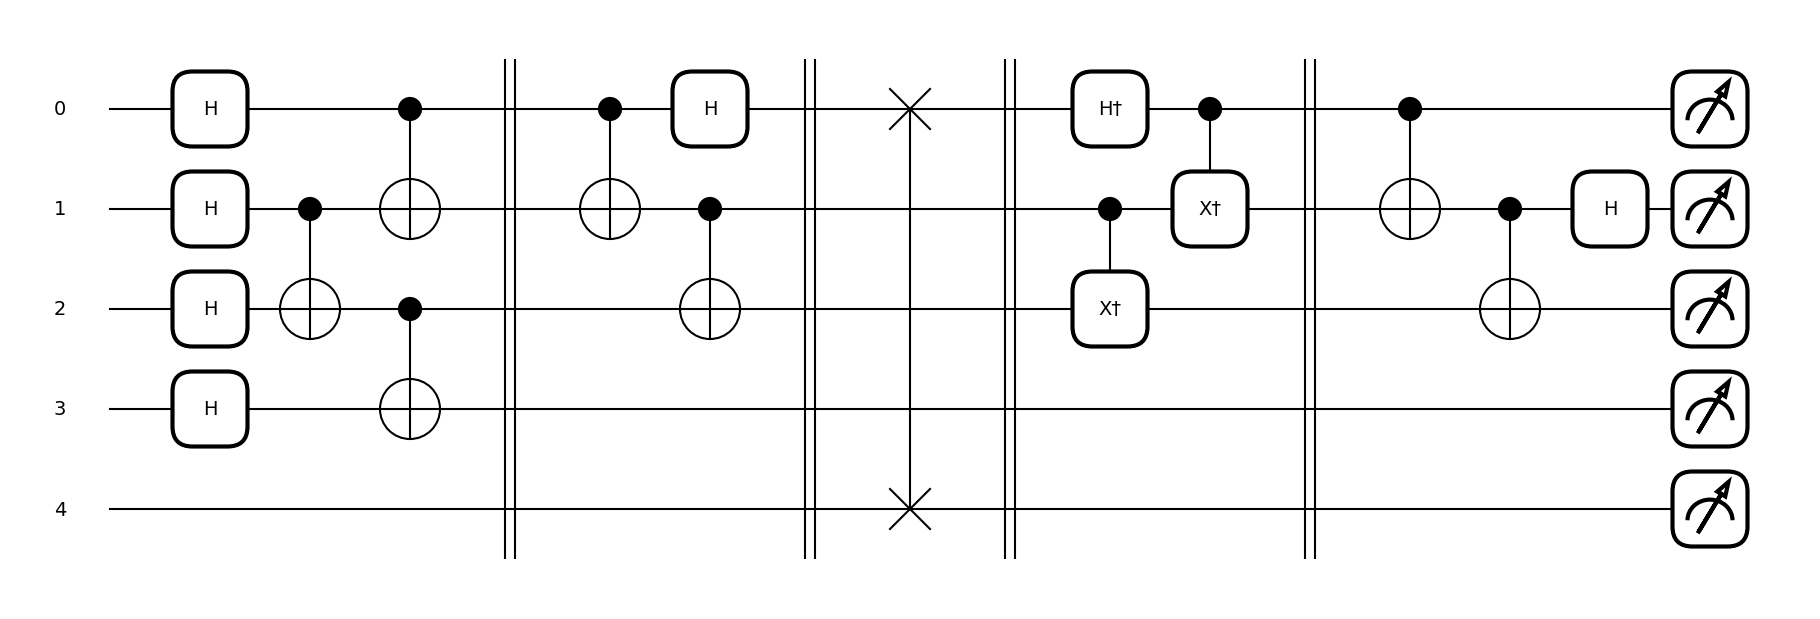

Sewing qubit 1
rho_1 = |0⟩⟨0| True
rho_0+n = |0⟩⟨0| True


In [6]:
dev = qml.device("lightning.qubit", wires=2*n)

@qjit
@qml.qnode(dev)
def sewing_1():
    U_test()              # some shallow unitary circuit
    qml.Barrier()
    V_0()                 # disentangle qubit 0
    qml.Barrier()
    qml.SWAP((0, n))      # swap out disentangled qubit 0 and n+0
    qml.Barrier()
    qml.adjoint(V_0)()    # repair circuit from V_0
    qml.Barrier()
    V_1()                 # disentangle qubit 1
    return qml.state()

# The Barriers are to see which part of the circuit corresponds to which gate
qml.draw_mpl(sewing_1)()
plt.show()

state = sewing_1()
dms = qml.math.reduce_statevector(state, indices=range(2*n))
r1, rn = qml.math.reduce_dm(dms, indices=[1]), qml.math.reduce_dm(dms, indices=[n])

print(f"Sewing qubit 1")
print(f"rho_1 = |0⟩⟨0| {jnp.allclose(r1, jnp.array([[1, 0], [0, 0]]))}")
print(f"rho_0+n = |0⟩⟨0| {jnp.allclose(rn, jnp.array([[1, 0], [0, 0]]))}")

We can continue this process for all qubits. Let us be tedious and do
all steps one by one.


In [7]:
@qjit
@qml.qnode(dev)
def sewing_2():
    U_test()              # some shallow unitary circuit
    V_0()                 # disentangle qubit 0
    qml.SWAP((0, n))      # swap out disentangled qubit 0 and n+0
    qml.adjoint(V_0)()    # repair circuit from V_0
    V_1()                 # disentangle qubit 1
    qml.SWAP((1, n + 1))  # swap out disentangled qubit 1 to n+1
    qml.adjoint(V_1)()    # repair circuit from V_1
    V_2()                 # disentangle qubit 2
    return qml.state()

state = sewing_2()
dms = qml.math.reduce_statevector(state, indices=range(2*n))
r2, rn, rn1 = qml.math.reduce_dm(dms, indices=[2]), qml.math.reduce_dm(dms, indices=[n]), qml.math.reduce_dm(dms, indices=[n+1])
print(f"Sewing qubit 2")
print(f"rho_2 = |0⟩⟨0| {jnp.allclose(r2, jnp.array([[1, 0], [0, 0]]))}")
print(f"rho_0+n = |0⟩⟨0| {jnp.allclose(rn, jnp.array([[1, 0], [0, 0]]))}")
print(f"rho_1+n = |0⟩⟨0| {jnp.allclose(rn1, jnp.array([[1, 0], [0, 0]]))}")

Sewing qubit 2
rho_2 = |0⟩⟨0| True
rho_0+n = |0⟩⟨0| True
rho_1+n = |0⟩⟨0| True


We continue to show that the swapped out wires remain decoupled, as well
as the qubit we are currently decoupling.


In [8]:
@qjit
@qml.qnode(dev)
def sewing_3():
    U_test()              # some shallow unitary circuit
    V_0()                 # disentangle qubit 0
    qml.SWAP((0, n))      # swap out disentangled qubit 0 and n+0
    qml.adjoint(V_0)()    # repair circuit from V_0
    V_1()                 # disentangle qubit 1
    qml.SWAP((1, n + 1))  # swap out disentangled qubit 1 to n+1
    qml.adjoint(V_1)()    # repair circuit from V_1
    V_2()                 # disentangle qubit 2
    qml.SWAP((2, n + 2))  # swap out disentangled qubit 2 to n+2
    qml.adjoint(V_2)()    # repair circuit from V_2
    V_3()                 # disentangle qubit 3
    return qml.state()

state = sewing_3()
dms = qml.math.reduce_statevector(state, indices=range(2*n))
r3, rn, rn1, rn2 = qml.math.reduce_dm(dms, indices=[3]), qml.math.reduce_dm(dms, indices=[n]), qml.math.reduce_dm(dms, indices=[n+1]), qml.math.reduce_dm(dms, indices=[n+2])
print(f"Sewing qubit 3")
print(f"rho_3 = |0⟩⟨0| {jnp.allclose(r3, jnp.array([[1, 0], [0, 0]]))}")
print(f"rho_0+n = |0⟩⟨0| {jnp.allclose(rn, jnp.array([[1, 0], [0, 0]]))}")
print(f"rho_1+n = |0⟩⟨0| {jnp.allclose(rn1, jnp.array([[1, 0], [0, 0]]))}")
print(f"rho_2+n = |0⟩⟨0| {jnp.allclose(rn2, jnp.array([[1, 0], [0, 0]]))}")

Sewing qubit 3
rho_3 = |0⟩⟨0| True
rho_0+n = |0⟩⟨0| True
rho_1+n = |0⟩⟨0| True
rho_2+n = |0⟩⟨0| True


After one final swap and repair, we arrive at a state where all original
qubits are decoupled. We just need to move them back to their original
position with a global SWAP. But not just that, we also now know that,
globally, the original $U^\text{test}$ is inverted.


In [9]:
@qjit
@qml.qnode(dev)
def V_dagger_test():
    U_test()              # some shallow unitary circuit
    V_0()                 # disentangle qubit 0
    qml.SWAP((0, n))      # swap out disentangled qubit 0 and n+0
    qml.adjoint(V_0)()    # repair circuit from V_0
    V_1()                 # disentangle qubit 1
    qml.SWAP((1, n + 1))  # swap out disentangled qubit 1 to n+1
    qml.adjoint(V_1)()    # repair circuit from V_1
    V_2()                 # disentangle qubit 2
    qml.SWAP((2, n + 2))  # swap out disentangled qubit 2 to n+2
    qml.adjoint(V_2)()    # repair circuit from V_2
    V_3()                 # disentangle qubit 3
    qml.SWAP((3, n + 3))  # swap out disentangled qubit 3 to n+3
    qml.adjoint(V_3)()    # repair circuit from V_3
    for i in range(n):    # swap back all decoupled wires to their original registers
        qml.SWAP((i + n, i))
    return qml.state()

psi0 = jnp.eye(2**4)[0] # |0>^n
state = V_dagger_test()
dms = qml.math.reduce_statevector(state, indices=range(2*n))
dm = qml.math.reduce_dm(dms, indices=[0, 1, 2, 3])
jnp.allclose(dm, jnp.outer(psi0, psi0))

Array(True, dtype=bool)

Everything after `U_test()` in `V_dagger_test` constitutes
$(V^\text{sew})^\dagger$.


In [10]:
def V_dagger():
    V_0()                 # disentangle qubit 0
    qml.SWAP((0, n))      # swap out disentangled qubit 0 and n+0
    qml.adjoint(V_0)()    # repair circuit from V_0
    V_1()                 # disentangle qubit 1
    qml.SWAP((1, n + 1))  # swap out disentangled qubit 1 to n+1
    qml.adjoint(V_1)()    # repair circuit from V_1
    V_2()                 # disentangle qubit 2
    qml.SWAP((2, n + 2))  # swap out disentangled qubit 2 to n+2
    qml.adjoint(V_2)()    # repair circuit from V_2
    V_3()                 # disentangle qubit 3
    qml.SWAP((3, n + 3))  # swap out disentangled qubit 3 to n+3
    qml.adjoint(V_3)()    # repair circuit from V_3
    for i in range(n):    # swap back all decoupled wires to their original registers
        qml.SWAP((i + n, i))

It is such that the action of $U^\text{test}$ on
$|0 \rangle^{\otimes n}$ is reverted when tracing out the ancilla
qubits. From the paper we know that, in fact, the action of the sewn
$V^\text{sew}$ overall is

$$V^\text{sew} |0^{\otimes 2n}\rangle = U \otimes U^\dagger |0^{\otimes 2n}\rangle.$$

$U$ acts on the first `n` qubits, whereas $U^\dagger$ acts on the `n`
ancilla qubits.


Numerical Experiment
--------------------

The actual learning in this procedure happens in obtaining the local
inversions $\{V_0, V_1, V_2, V_3\}$. The paper relies on existence
proofs from gate synthesis and suggests brute-force searching via
enumerate-and-test to find suitable $\{V_i\}$. The idea is to
essentially take a big enough set of possible $\{V_i\}$ and post-select
those that fulfill
$||V^\dagger_i U^\dagger P_i U V_i - P_i|| < \epsilon$ for
$P_i \in \{X, Y, Z\}$, which the authors show suffices as a criterium to
have an approximate local inversion.

Instead of doing that, let us here look at an explicit example by
constructing a target unitary of some structure and a variational Ansatz
for the local inversions that has a different structure. There are many
ways to obtain local inversions, this is just one we find more
convenient.

First, let us construct the target unitary


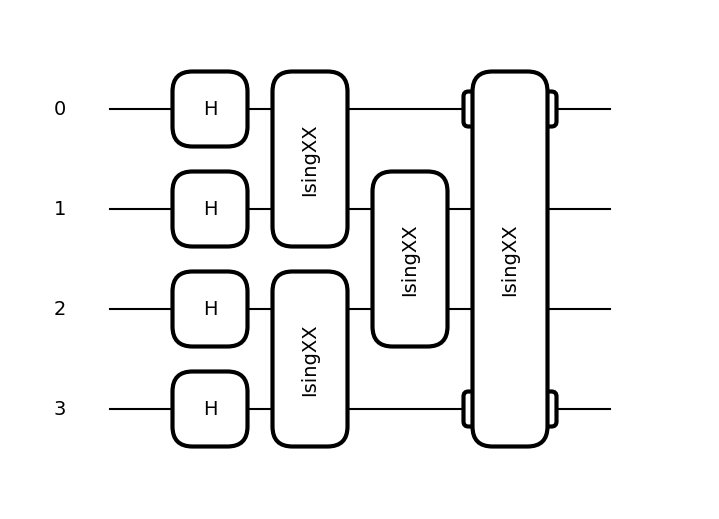

In [11]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

n = 4
wires = jnp.array(range(n))
U_params = jax.random.normal(jax.random.PRNGKey(0), shape=(2, n//2), dtype=float)

def U_target(wires):
    for i in range(n):
        qml.Hadamard(wires=wires[i])
    # brick-wall ansatz
    for i in range(0, n, 2):
        qml.IsingXX(U_params[0, i], wires=(wires[i], wires[(i+1)%len(wires)]))
    for i in range(1, n, 2):
        qml.IsingXX(U_params[1, i], wires=(wires[i], wires[(i+1)%len(wires)]))

qml.draw_mpl(U_target)(wires.tolist())
plt.show()

Putting on blindfolds and assuming we don\'t know the circuit structure
of $U^\text{target}$, we set up a variational Ansatz for the local
inversions $V_i$ with the following structure.


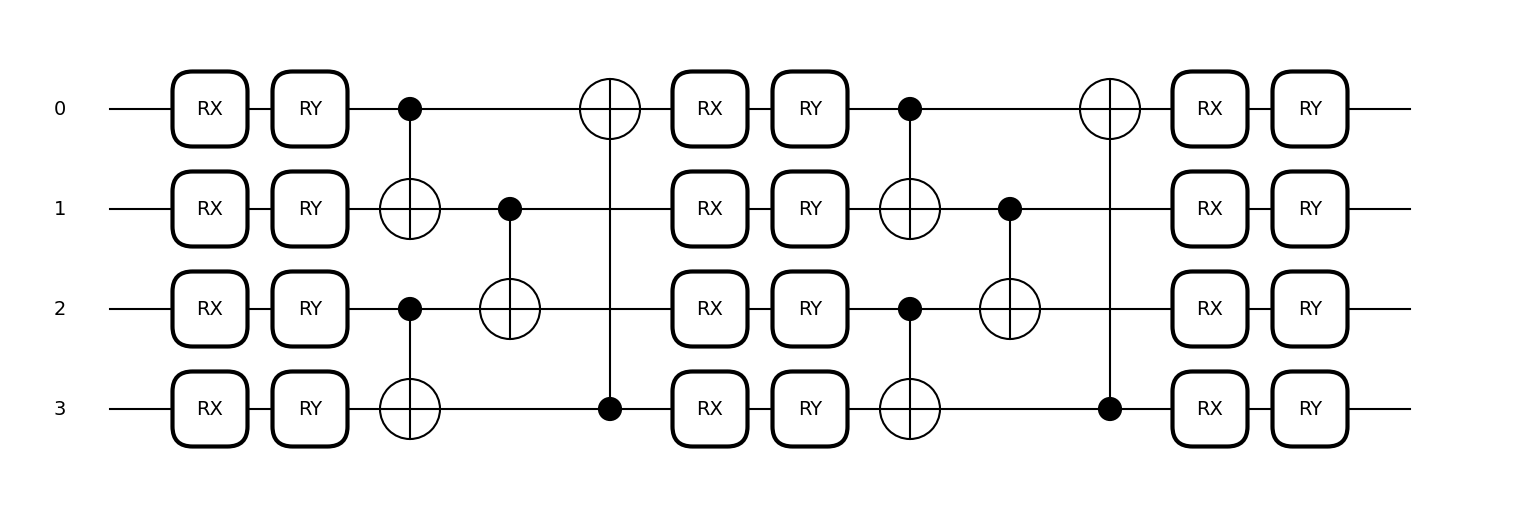

In [12]:
n_layers = 2

def V_i(params, wires):

    for i in range(n):
        qml.RX(params[0, 0, i], i)
    for i in range(n):
        qml.RY(params[0, 1, i], i)
    
    for ll in range(n_layers):
        for i in range(0, n, 2):
            qml.CNOT((wires[i], wires[i+1]))
        for i in range(1, n, 2):
            qml.CNOT((wires[i], wires[(i+1)%n]))
        for i in range(n):
            qml.RX(params[ll+1, 0, i], i)
        for i in range(n):
            qml.RY(params[ll+1, 1, i], i)

params = jax.random.normal(jax.random.PRNGKey(10), shape=(n_layers+1, 2, n), dtype=float)

qml.draw_mpl(V_i)(params, wires.tolist())
plt.show()

Next, we are going to run optimizations for each $V_i$ to find a local
inversion. For that we need some boilerplate code, see our [demo](https://docs.pennylane.ai/projects/catalyst/en/latest/demos/qml_optimization.html) on optimizing quantum circuits in jax.


In [13]:
import optax
from datetime import datetime
from functools import partial

X, Y, Z = qml.PauliX, qml.PauliY, qml.PauliZ

@qjit(static_argnums=[0, 2], autograph=True)
def run_opt(cost, theta, index, n_epochs=100, lr=0.1, b1=0.9, b2=0.999):
    optimizer = optax.adam(learning_rate=lr, b1=b1, b2=b2)
    opt_state = optimizer.init(theta)

    min_energy = jnp.inf
    val = jnp.float64(0)
    opt_state_list, opt_state_tree_def = tree_flatten(opt_state)
    adam_count, adam_mu, adam_nu = opt_state_list

    def step(adam_count, adam_mu, adam_nu, theta, val, min_energy):
        val, grad_circuit = cost(theta, index), grad(cost)(theta, index)
        updates, opt_state = optimizer.update(grad_circuit, tree_unflatten(opt_state_tree_def, [adam_count, adam_mu, adam_nu]))
        opt_state_list, _ = tree_flatten(opt_state)
        adam_count, adam_mu, adam_nu = opt_state_list
        theta = optax.apply_updates(theta, updates)
        min_energy = jnp.minimum(val, min_energy)
        return adam_count, adam_mu, adam_nu, theta, val, min_energy

    for i in range(n_epochs):
        adam_count, adam_mu, adam_nu, theta, val, min_energy = step(adam_count, adam_mu, adam_nu, theta, val, min_energy)

    return theta, val, min_energy

## 2x wires for circuit sewing 
dev = qml.device("lightning.qubit", wires=n*2)

As a cost function, we perform state tomography after applying
$U^\text{target}$ and our Ansatz $V_i$. Our aim is to bring the state on
qubit `i` back to the north pole of the Bloch sphere, and we specify our
cost function accordingly.


In [14]:
@qjit
@qml.qnode(dev)
def qnode_i(params, i):
    U_target(wires)
    V_i(params, wires)
    return [qml.expval(P(i)) for P in [X, Y, Z]]
    
def cost_i(params, i):
    x, y, z = qnode_i(params, i)
    return x**2 + y**2 + (1-z)**2

We can now run the optimization. We see that in that case it suffices to
use the random initial values from above for each optimization.


In [15]:
params_i = []
for i in range(n):
    t0 = datetime.now()
    theta, val, min_energy = run_opt(cost_i, params, i)
    t1 = datetime.now()
    print(f"final loss: {val}; min loss: {min_energy}; after {t1 - t0}")
    params_i.append(theta)

final loss: 4.168309870147671e-05; min loss: 4.168309870147671e-05; after 0:00:01.881214
final loss: 4.426389047114445e-06; min loss: 4.426389047114445e-06; after 0:00:01.588220
final loss: 7.119522980852351e-06; min loss: 6.622691688632588e-06; after 0:00:01.690259
final loss: 3.795733855917371e-06; min loss: 3.4988574855745106e-06; after 0:00:01.623869


For consistency, we check the resulting coordinates of qubit `i` on the
Bloch sphere.


In [16]:
for i in range(n):
    X_res, Y_res, Z_res = qnode_i(params_i[i], i)
    print(f"Bloch sphere coordinates of qubit {i} after inversion: {X_res:.5f}, {Y_res:.5f} {Z_res:.5f}")

Bloch sphere coordinates of qubit 0 after inversion: -0.00183, -0.00021 0.99393
Bloch sphere coordinates of qubit 1 after inversion: -0.00016, 0.00015 0.99795
Bloch sphere coordinates of qubit 2 after inversion: -0.00085, 0.00013 0.99753
Bloch sphere coordinates of qubit 3 after inversion: 0.00062, 0.00044 0.99837


We see that they are all approximately inverting the circuit as the
resulting state is close to $|0\rangle$ (associated with coordinates
$(x, y, z) = (0, 0, 1)$). With these local inversions, we can sew
together again a unitary that globally inverts the circuit.


In [17]:
def V_sew():
    for i in range(n):
        # local sewing: inversion, exchange, heal
        V_i(params_i[i], range(n))
        qml.SWAP((i, i+n))
        qml.adjoint(V_i)(params_i[i], range(n))

    # global SWAP
    for i in range(n):
        qml.SWAP((i, i+n))

@qml.qnode(dev, interface="jax")
def sewing_test():
    U_target(range(n))
    V_sew()
    return qml.density_matrix(range(4))

print(jnp.allclose(sewing_test(), jnp.outer(psi0, psi0), atol=1e-1))

True


The final test confirms that $V^\text{sew}$ approximately inverts
$U^\text{target}$ on the system wires.

Conclusion
----------

We saw how one can construct a global inversion from sewing together
local inversions. This is a powerful new technique that may find
applications in different domains of quantum computing. The technique
cleverly circumvents the quantum marginal problem of constructing a
global inversion from local ones compatible with each other.

The authors use this technique to prove that constant depth quantum
circuits are learnable (i.e. can be reconstructed) in a variety of
different scenarios.

::: {.note}
::: {.title}
Note
:::

We mainly focussed on the case of constructing $V^\text{sew}$ such that
$V^\text{sew} U |0 \rangle^{\otimes n} = |0 \rangle^{\otimes n}$ as it
already nicely captures the main technical method that is circuit
sewing. This is different to learning the full unitary, i.e. $V$ such
that $U V = 1$.

For this, the circuit sewing works in the exact same way. The main
difference is that the local inversions are now full inversions in the
sense of $\text{tr}_{\neq 0}\left[V_i U\right] = \mathbb{1}_i$ (whereas
before we just had
$V_i U |0 \rangle^{\otimes n} = |0 \rangle^{\otimes n}$, which is a
simpler case). The authors show that a sufficient condition for full
inversion is achieved by minimizing

$$\sum_{P\in \{X, Y, Z\}} ||V^\dagger_i U^\dagger P_i U V_i - P_i ||.$$

In the paper, the authors suggest to brute-force search the whole space
of possible $V_i$ and post-select those for which the distance to $P_i$
is small. The terms are evaluated by randomly sampling input (product)
states $|\phi_j\rangle$ and computing expectation values of
$\langle \phi_j | V^\dagger_i U^\dagger P_i U V_i |\phi_j\rangle$. In
particular, samples for all possible candidates of $V_i$ are generated.
Another possibility is to perform state tomography of the single qubit
states and compare that with the input state. Either way, the circuit
sewing after obtaining the learned local inversions is the same as
described above.
:::
